## Æther: Pipeline


In [3]:
import os
import torch
import pandas as pd
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
import torch.nn as nn
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

/home/cajas/Archivos/tec/semestre_8/tc3002b/tc3002b/aether/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
def read_file(base_dir, file_id):
    path = base_dir / f"{file_id}.java"
    if path.exists():
        try:
            return path.read_text(encoding="utf-8")

        except UnicodeDecodeError:
            return path.read_text(encoding="latin-1")

## Dataset


In [5]:
# print working directory
print("Current working directory:", os.getcwd())

Current working directory: /home/cajas/Archivos/tec/semestre_8/tc3002b/tc3002b/aether/research/notebooks/testing_cajas


In [6]:
df = pd.read_csv("../../labels/conplag_labels.csv")

labeled_pairs = df[["id1", "id2", "plagio"]].values.tolist()
base_dir = Path("../../datasets/conplag_preprocesed")
files = {}

for id1, id2, _ in labeled_pairs:

    if id1 not in files:
        file1 = read_file(base_dir, id1)
        files[id1] = file1
    else:
        file1 = files[id1]

    if id2 not in files:
        file2 = read_file(base_dir, id2)
        files[id2] = file2
    else:
        file2 = files[id2]

    if file1 is None or file2 is None:
        raise ValueError(f"File not found: {id1} or {id2}")

In [49]:
from transformers import pipeline

encode = pipeline(
    "feature-extraction",
    model="huggingface/CodeBERTa-small-v1",
    tokenizer="huggingface/CodeBERTa-small-v1",
    device=0,
    truncation=True,
    tokenize_kwargs={"padding": "max_length"},
)

Device set to use cuda:0


In [53]:
for id1, id2, label in labeled_pairs:
    code1 = files[id1]
    code2 = files[id2]

    # Encode the code snippets
    code1_embedding = encode(code1)
    code2_embedding = encode(code2)

    code1_embedding = np.array(code1_embedding)
    code2_embedding = np.array(code2_embedding)

    # Drop the first dimension
    code1_embedding = code1_embedding[0]
    code2_embedding = code2_embedding[0]

    # Reshape the embeddings to 1D
    code1_embedding = code1_embedding.reshape(-1)
    code2_embedding = code2_embedding.reshape(-1)

    # # Calculate the cosine similarity
    similarity = np.dot(code1_embedding, code2_embedding) / (
        np.linalg.norm(code1_embedding) * np.linalg.norm(code2_embedding)
    )

    # Add the similarity to the dataframe
    df.loc[
        (df["id1"] == id1) & (df["id2"] == id2), "similarity"
    ] = similarity
df.to_csv("similarity.csv", index=False)

In [61]:
def find_optimal_threshold(y_true, y_scores):
    """
    Find the optimal threshold for binary classification using ROC curve.
    """
    from sklearn.metrics import roc_curve

    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    return optimal_threshold

Accuracy: 0.80
              precision    recall  f1-score   support

           0       0.81      0.94      0.87       660
           1       0.73      0.42      0.53       251

    accuracy                           0.80       911
   macro avg       0.77      0.68      0.70       911
weighted avg       0.79      0.80      0.78       911



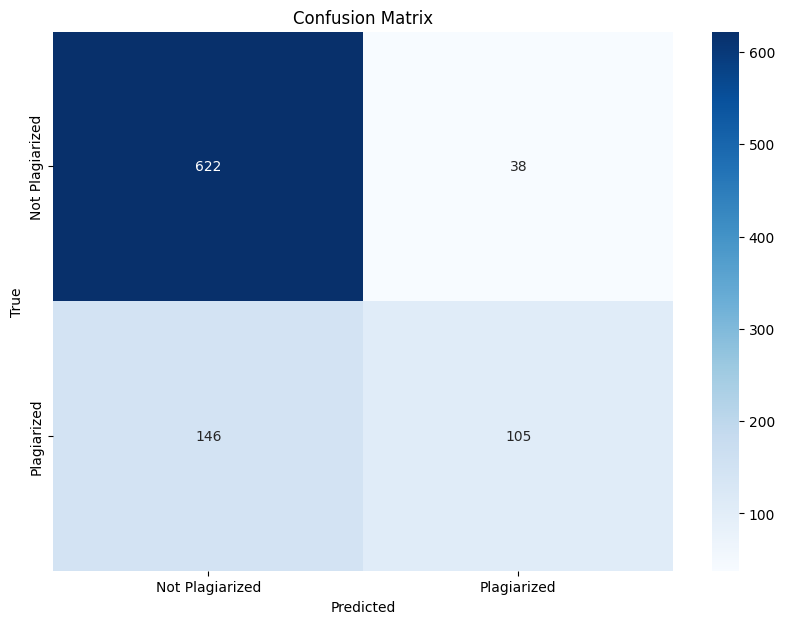

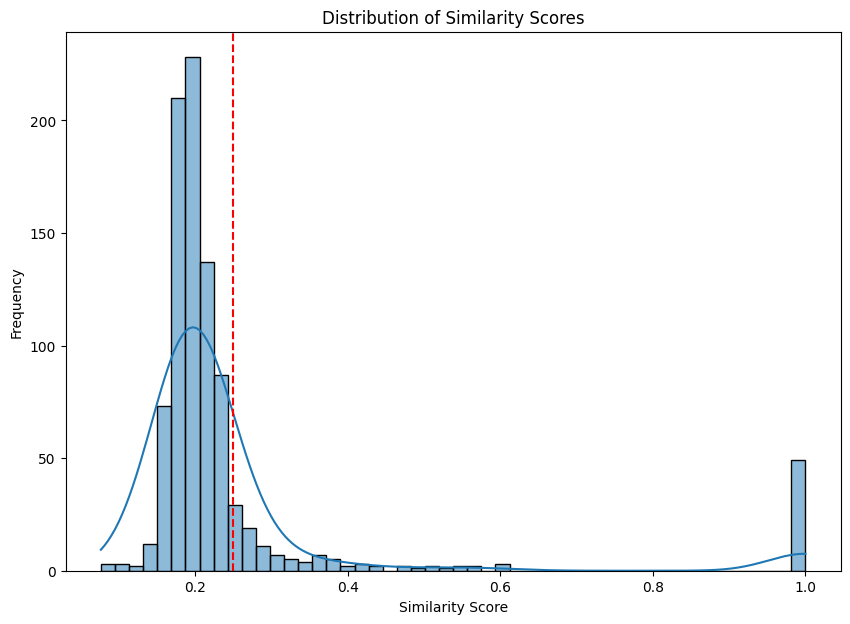

In [ ]:
threshold = find_optimal_threshold(df["plagio"].values, df["similarity"].values)
print(f"Optimal threshold: {threshold:.2f}")
df["predicted"] = df["similarity"].apply(lambda x: 1 if x > threshold else 0)

# Calculate the accuracy
accuracy = (df["predicted"] == df["plagio"]).mean()
print(f"Accuracy: {accuracy:.2f}")
# Calculate the confusion matrix
cm = confusion_matrix(df["plagio"], df["predicted"])
# Calculate the classification report
report = classification_report(df["plagio"], df["predicted"])
print(report)
# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Not Plagiarized", "Plagiarized"],
    yticklabels=["Not Plagiarized", "Plagiarized"],
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
# Plot the distribution of the similarity scores
plt.figure(figsize=(10, 7))
sns.histplot(df["similarity"], bins=50, kde=True)
plt.axvline(threshold, color="red", linestyle="--")
plt.xlabel("Similarity Score")
plt.ylabel("Frequency")
plt.title("Distribution of Similarity Scores")
plt.show()
# Plot the distribution of the similarity scores for plagiarized and not plagiarized

## Detection


## Execution
